# Sentiment Analysis of Donesi.com Reviews

## Introduction

<b>Donesi.com</b> is free online service for food ordering. Restaurants are connected to the Internet and they can accept and answer orders from this service. All prices listed on <a href="www.donesi.com">Donesi.com</a> are the same or lower as in participating restaurants. <br /><br />
<img src="http://www.donesi.com/images/logo.png"><br />
This service is connected with restaurants from these cities:
<ol>
    <li>
    <b>Serbia</b> (10): Belgrade, Novi Sad, Niš, Subotica, Pančevo, Zrenjanin, Kragujevac, Kruševac, Kraljevo and Čačak.
    </li><br />
    <li>
    <b>Bosnia and Herzegovina</b> (8): Sarajevo, Banja Luka, Bijeljina, Brčko, Prijedor, Zenica, Tuzla and Mostar.
    </li><br />
    <li>
    <b>Montenegro</b> (8): Podgorica, Bar, Budva, Kotor, Tivat, Herceg Novi, Nikšić and Bijelo Polje.
    </li><br />
</ol>

## Exploratory Data Analysis

After getting permission from Donesi.com maintainers, the website was <a href="https://github.com/vdragan1993/sentiment-analysis/blob/master/src/crawler.py">crawled</a>. Initially, 65748 reviews were collected, including restaurant and user data. 
<br />
First step after data acquisition was removing non-ascii characters. Therefore, next steps were done:
<ul>
    <li>
    Cyrillic reviews were removed
    </li><br />
    <li>
    Serbian Latin characters were converted into the corresponding replacements (e.g. Č -> Ch, Đ -> dj)
    </li><br />
    <li>
    Other reviews with non-ASCII characters were removed.
    </li><br />
</ul>
After finishing the task above, empty reviews(empty review title and empty review content) were also removed. Result of this data preprocessing are shown in the table below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# reading count file and printing table
count = pd.read_csv("data/count.csv")
count.head()

,Country,Crawled,Filtered,Lost
0,Bosnia and Herzegovina,5231,4992,239 (4.5%)
1,Montenegro,2227,2188,39 (1.75%)
2,Serbia,58290,57784,506 (0.8%)
3,Total,65748,64964,784 (1.2%)


As we can see in the table above, reviews are split into groups based on the country. There's no significant data loss after preprocessing. All further analysis will be based on the filtered data.<hr /> 
Next steps:
<ul>
    <li>calculate average rating</li><br />
    <li>calculate average review title length</li><br />
    <li>calculate average review content length.</li><br />
    <li>check reviews distribution based on rating range, from 1 to 5</li><br />
</ul>

In [2]:
from openpyxl import load_workbook

def get_ratings_statistics(file_name, color_name):
    title_len = 0
    content_len = 0
    total_rating = 0
    total_count = 0
    ratings_distribution = {1:0, 2:0, 3:0, 4:0, 5:0}
    # reading from total filtered ratings 
    wb = load_workbook(filename=file_name)
    ws = wb['Sheet1']
    index = 0
    for row in ws.rows:
        index += 1
        if index > 1: # skipping header
            rating = float(row[6].value)
            title_len += len(row[4].value)
            content_len += len(row[5].value)
            total_rating += rating
            total_count += 1
            # assign to appropriate rating range
            if 0.0 <= rating < 1.5:
                ratings_distribution[1] += 1
            elif 1.5 <= rating < 2.5:
                ratings_distribution[2] += 1
            elif 2.5 <= rating < 3.5:
                ratings_distribution[3] += 1
            elif 3.5 <= rating < 4.5:
                ratings_distribution[4] += 1
            else:
                ratings_distribution[5] += 1
    
    # calculating averages 
    print("\nAverage review rating is: {}".format(round(total_rating/total_count, 2)))
    print("Average review title length is: {}".format(round(title_len/total_count, 2)))
    print("Average review content length is: {}".format(round(content_len/total_count, 2)))
    
    # plot
    print("\nRatings distribution: ")
    plt.bar(range(len(ratings_distribution)), ratings_distribution.values(), align='center', color=color_name)
    plt.xticks(range(len(ratings_distribution)), ratings_distribution.keys(), rotation=25)

#### Ratings statistics for every country

Ratings statistics for Bosnia and Herzegovina: 

Average review rating is: 4.24
Average review title length is: 11.88
Average review content length is: 79.8

Ratings distribution: 


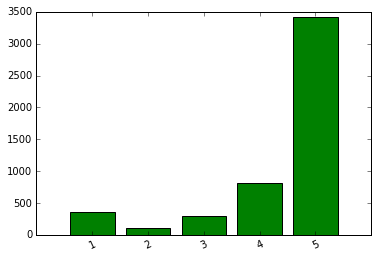

In [3]:
print ("Ratings statistics for Bosnia and Herzegovina: ")
get_ratings_statistics("data/filtered/fbih.xlsx", "green")

Ratings statistics for Montenegro: 

Average review rating is: 4.2
Average review title length is: 12.24
Average review content length is: 79.22

Ratings distribution: 


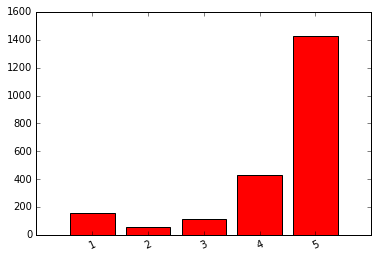

In [4]:
print ("Ratings statistics for Montenegro: ")
get_ratings_statistics("data/filtered/fcg.xlsx", "red")

Ratings statistics for Serbia: 

Average review rating is: 4.13
Average review title length is: 13.82
Average review content length is: 187.44

Ratings distribution: 


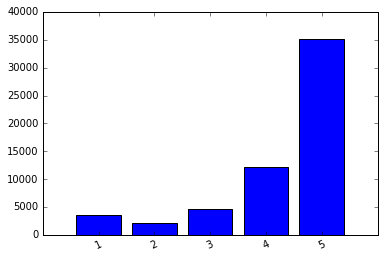

In [5]:
print ("Ratings statistics for Serbia: ")
get_ratings_statistics("data/filtered/fsrb.xlsx", "blue")

#### Total ratings statistics

Ratings statistics for all reviews: 

Average review rating is: 4.14
Average review title length is: 13.62
Average review content length is: 175.52

Ratings distribution: 


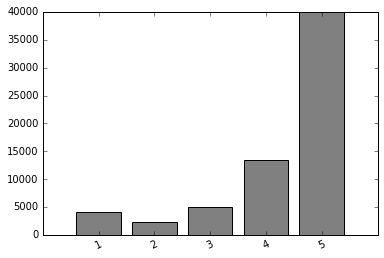

In [6]:
print ("Ratings statistics for all reviews: ")
get_ratings_statistics("data/filtered/fall.xlsx", "grey")

From statistics above, we can see that there's a significant disproportion between positive and negative reviews. Average rating of reviews is quite high (4.14 of 5). Also, we can conclude that average user from Serbia writes longer review, and rates restaurant with a slightly lower rating.

### Sorting out reviews

All reviews with total rating of 3.5 or more represents positive review. New review in sorted file is: title + comment.

In [7]:
import xlsxwriter

def sort_reviews(input_file, output_file, color_name):
    # preparing output file
    workbook = xlsxwriter.Workbook(output_file)
    worksheet = workbook.add_worksheet()
    # prepare columns
    worksheet.set_column('A:A', 120)
    worksheet.set_column('B:B', 10)
    # enable bold header
    bold = workbook.add_format({'bold':True})
    # write header
    worksheet.write(0, 0, 'Review', bold)
    worksheet.write(0, 1, 'Sentiment', bold)
    
    # processing input file
    wb = load_workbook(filename=input_file)
    ws = wb['Sheet1']
    
    pos_len = 0
    pos_count = 0
    neg_len = 0
    neg_count = 0
    index = 0
    skip_first = 0
    
    for row in ws.rows:
        skip_first += 1
        
        if skip_first > 1:
            index += 1
            title = row[4].value
            review = row[5].value
            rating = float(row[6].value)
            
            if 0 <= rating < 3.5:
                neg_len += len(title + ' ' + review)
                neg_count += 1
                new_review = title + ' ' + review
                worksheet.write(index, 0, new_review.lower())
                worksheet.write(index, 1, 0)
            elif rating >= 3.5:
                pos_len += len(title + ' ' + review)
                pos_count += 1
                new_review = title + ' ' + review
                worksheet.write(index, 0, new_review.lower())
                worksheet.write(index, 1, 1)
        
    # close output file
    workbook.close()
    
    print("\nAverage length of positive review: {} of total {} reviews".format(round(pos_len/pos_count, 2), pos_count))
    print("Average length of negative review: {} of total {} reviews".format(round(neg_len/neg_count, 2), neg_count))
        
    ratings_distribution = {'Positive':pos_count, 'Negative':neg_count}
    print("\nRatings distribution:")
    plt.bar(range(len(ratings_distribution)), ratings_distribution.values(), align='center', color=color_name)
    plt.xticks(range(len(ratings_distribution)), ratings_distribution.keys())

Bosnia and Herzegovina: 

Average length of positive review: 82.32 of total 4227 reviews
Average length of negative review: 149.95 of total 765 reviews

Ratings distribution:


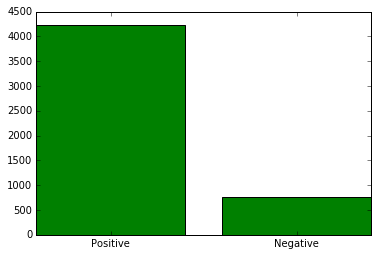

In [8]:
print("Bosnia and Herzegovina: ")
sort_reviews("data/filtered/fbih.xlsx", "data/posneg/pnbih.xlsx", "green")

Montenegro: 

Average length of positive review: 79.56 of total 1854 reviews
Average length of negative review: 164.05 of total 334 reviews

Ratings distribution:


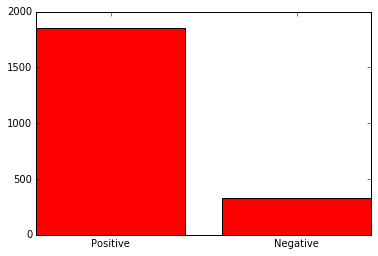

In [9]:
print("Montenegro: ")
sort_reviews("data/filtered/fcg.xlsx", "data/posneg/pncg.xlsx", "red")

Serbia: 

Average length of positive review: 186.87 of total 47420 reviews
Average length of negative review: 272.68 of total 10364 reviews

Ratings distribution:


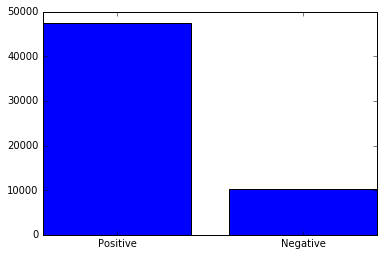

In [10]:
print("Serbia: ")
sort_reviews("data/filtered/fsrb.xlsx", "data/posneg/pnsrb.xlsx", "blue")

All reviews: 

Average length of positive review: 174.89 of total 53501 reviews
Average length of negative review: 261.32 of total 11463 reviews

Ratings distribution:


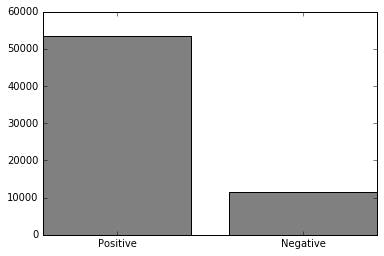

In [11]:
print("All reviews: ")
sort_reviews("data/filtered/fall.xlsx", "data/posneg/pnall.xlsx", "grey")

As we can see from results above, there's almost 5 times more positive reviews than negative ones. Also, negative reviews are bit longer than the positive ones.

### Word frequency

Displaying frequency word clouds, based on current status of dataset, before text processing.

In [12]:
from wordcloud import WordCloud

def get_word_freq(input_file, sentiment):
    total_text = ''
    wb = load_workbook(filename=input_file)
    ws = wb['Sheet1']
    index = 0
    
    # reading text
    for row in ws.rows:
        index += 1
        if index > 1:
            review = row[0].value
            sent = row[1].value
            if sentiment is None:
                total_text += review + ' '
            else:
                if int(sent) == sentiment:
                    total_text += review + ' '
                    
    # generating diagram
    wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(total_text)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
    
def display_word_freq(input_file):
    print("Positive reviews")
    get_word_freq(input_file, 1)
    print("Negative reviews")
    get_word_freq(input_file, 0)
    print("All reviews")
    get_word_freq(input_file, None)

Bosnia and Herzegovina: 

Positive reviews


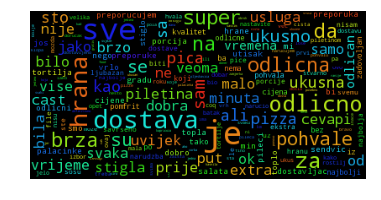

Negative reviews


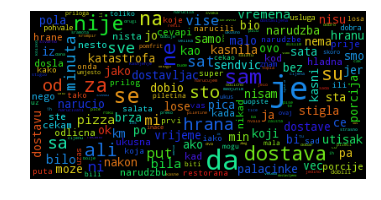

All reviews


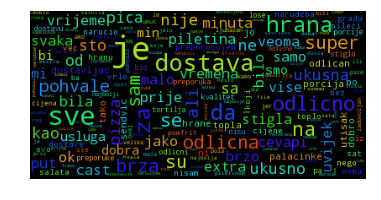

In [13]:
print('Bosnia and Herzegovina: \n')
display_word_freq("data/posneg/pnbih.xlsx")

Montenegro: 

Positive reviews


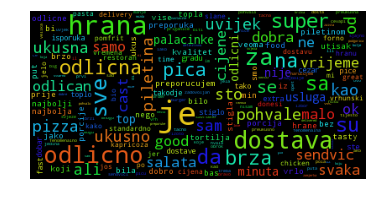

Negative reviews


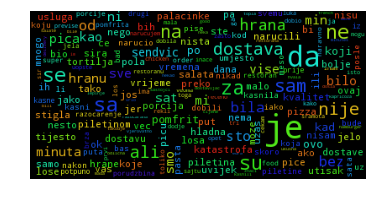

All reviews


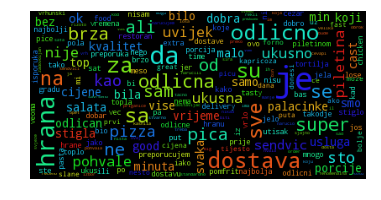

In [14]:
print ('Montenegro: \n')
display_word_freq("data/posneg/pncg.xlsx")

Serbia: 

Positive reviews


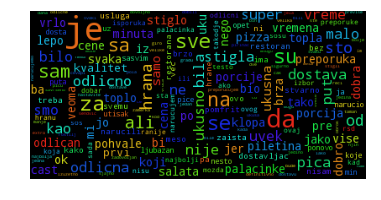

Negative reviews


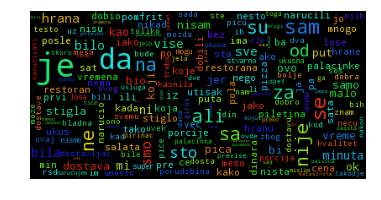

All reviews


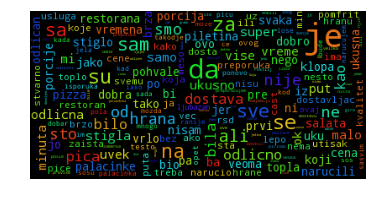

In [15]:
print ('Serbia: \n')
display_word_freq("data/posneg/pnsrb.xlsx")

Total: 

Positive reviews


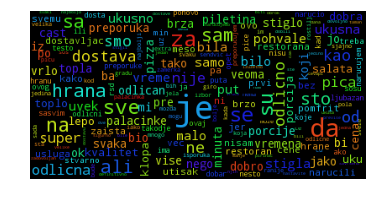

Negative reviews


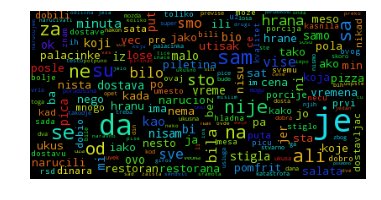

All reviews


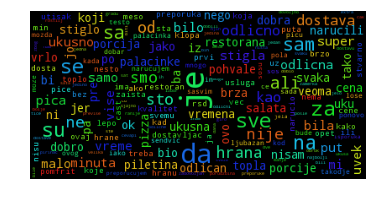

In [17]:
print('Total: \n')
display_word_freq("data/posneg/pnall.xlsx")

## Text Processing

All text processing steps will be applied on all reviews.

### Interesting Interpunction and Emoticons

In order to replace some "codes" with words, we need to check their frequency of occurence.

In [24]:
def check_occurrence(input_file):
    # define codes
    signs_freq = {'+':0, '-':0, '!':0, ':)':0, ':-)':0, ':]':0, ':-]':0, ':3':0, ':-3':0, '=]':0, '=)':0, 
                 ':D':0, ':-D':0, 'xD':0, 'x-D':0, '=D':0, '=3':0, ':-))':0, ':(':0, ':-(':0, ':[':0, ':-[':0,
                 ':@':0, ":'(":0, ":'-(":0, ':O':0, ':-O':0, ':o':0, ':-o':0, ':*':0, ':-*':0,
                 ';)':0, ';-)':0, ';]':0, ';-]':0, ':|':0, ':-|':0, ':/':0, ':-/':0, 'o.o':0, 'O.O':0}
    # read and count
    wb = load_workbook(filename=input_file)
    ws = wb['Sheet1']
    index = 0
    for row in ws.rows:
        index += 1
        if index > 1:
            review = str(row[0].value)
            for code in signs_freq:
                if code in review:
                    signs_freq[code] += 1
    
    
    print('\nFrequency of occurence: ')
    for key,value in signs_freq.items():
        print(str(key) + "  <->  " + str(value) + '\n' )

In [26]:
check_occurrence("data/posneg/pnall.xlsx")


Frequency of occurence: 
:-O  <->  0

;]  <->  3

;)  <->  787

:O  <->  0

:]  <->  10

:3  <->  92

:o  <->  27

:-[  <->  0

:(  <->  457

=]  <->  2

!  <->  21576

:-]  <->  0

:'-(  <->  0

:@  <->  2

:'(  <->  5

o.o  <->  33

:-3  <->  0

:|  <->  2

=)  <->  45

:)  <->  8809

:-D  <->  0

:-/  <->  6

=D  <->  0

:-(  <->  23

x-D  <->  0

-  <->  9070

:[  <->  0

:-o  <->  0

:-)  <->  674

:-))  <->  37

xD  <->  0

;-)  <->  88

:*  <->  22

:/  <->  147

O.O  <->  0

;-]  <->  0

:-*  <->  5

:-|  <->  2

:D  <->  0

+  <->  2074

=3  <->  3

